## Import Library

In [24]:
!pip install --upgrade pythainlp
!pip install pyLDAvis
!pip install emoji
!pip install wordcloud

Requirement already up-to-date: pythainlp in /Users/abcd/opt/anaconda3/lib/python3.7/site-packages (2.3.1)


In [25]:
!pip uninstall -U scikit-learn


Usage:   
  pip uninstall [options] <package> ...
  pip uninstall [options] -r <requirements file> ...

no such option: -U


In [26]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /Users/abcd/opt/anaconda3/lib/python3.7/site-packages (0.24.2)


In [27]:
!pip install marisa-trie
!pip install pythainlp -U

Requirement already up-to-date: pythainlp in /Users/abcd/opt/anaconda3/lib/python3.7/site-packages (2.3.1)


In [28]:
#conda install -c conda-forge imbalanced-learn
#!pip install -U scikit-learn
#!pip install -U imbalanced-learn
#!pip install --upgrade scikit-learn

In [29]:
import numpy as np
import pandas as pd 
import re
import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.tokenize import word_tokenize, Tokenizer
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
#import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
from pythainlp.util.trie import Trie
from pythainlp.util import normalize

In [31]:
df = pd.read_excel("./Shopee_Tweet_NEW.xlsx")

In [32]:
df.head()

,Create_at,clean_text,Sentiment,Topics
0,2021-01-05,ใช่ค่ะ ตอนแรกบอกว่าให้กดรับของได้เลยแล้วจะส่งใ...,neg,Company
1,2021-01-05,อยากให้เรื่องนี้แมส เผื่อว่า จะออกมารับผิดชอบอ...,neg,Company
2,2021-02-06,ขอบคุณบริษัทช้อปปี้มากฮะที่แอดมินพาพี่มายกับอา...,pos,Company
3,2021-03-26,บอกลาบริษัทช้อปปี้ก่อนนะ แอดมินแบบนี้ ซื้อด้วย...,neg,Company
4,2021-02-01,เรากดสั่งของไปรอของมาจนวันนี้ ไม่ส่งซักที วันน...,neg,Company


## EDA

### Drop column

In [33]:
df.drop(columns=["Create_at"],inplace=True)

### Check Missing Value

In [34]:
np.sum(df.isnull())

clean_text    0
Sentiment     0
Topics        0
dtype: int64

## Analytics

In [35]:
aspect_counts = (df.groupby(['Topics'])['Sentiment']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('Sentiment'))

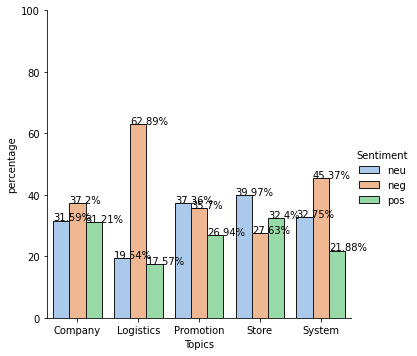

In [36]:
g_1 = sns.catplot(x='Topics',y='percentage',hue='Sentiment',kind='bar',data=aspect_counts,
                  hue_order=['neu', 'neg', 'pos'],
                  col_order=['Company', 'Promotion', 'Store', 'System','Logistics'],palette="pastel", edgecolor=".1")
g_1.ax.set_ylim(0,100)
for p in g_1.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g_1.ax.text(txt_x,txt_y,txt)

## Pre Processing

### 1. Cleansing

In [37]:
## Add word in dict
custom_dict = set(thai_words())

Company_ = 'บริษัทช้อปปี้ แอดมิน คอลเซ็นเตอร์ เจ้าหน้าที่ พนักงาน บริษัท ค่าบริการ รับผิดชอบ ติดต่อ โกงเงิน บัญชี ดำเนินการ แบ่งชนชั้น คุยกับพนักงาน ติดต่อ บริการ แจ้ง ระดับ พรีเมียม เมมเบอร์ แบน เลิกใช้ สื่อสาร ร้องเรียน เลิกช้อป เว็บไซต์ เบอร์ โทร เมล สนใจ เพิกเฉย รอสาย ตัดสาย ด่วน เมล โทร ศูนย์บริการ ปัญหา ชดเชย องค์กร เลิกสั่ง ประทับใจ แนะนำ ชี้แจง นโยบาย สมาชิก การตลาด โฆษณา ลูกค้า ผู้ใช้บริการ แพลตฟอร์ม โฆษณา'
Company_Topics = Company_.split(' ')

Logistics_ = 'ไม่ติดต่อ ยกเลิก รอ ช้า นาน ชั่วโมง ไม่ได้รับ ไม่ได้สินค้า ปัญหา ผู้ส่ง พนักงาน ขนส่ง รอนาน บริการ ไม่โทรมา ส่ง ไม่มาส่ง ไม่ส่ง สุภาพ บอกทาง เชค เช็ค ตรวจ ที่อยู่ ส่งช้า ส่งเร็ว ส่งไว โทรมา ไม่โทร ไม่รับ เลือกขนส่ง เลือกขนส่งไม่ได้ เลือกบริษัทขนส่ง ได้ของ ส่งของ กำหนด บริษัทขนส่ง ค่าส่ง เก็บเงินปลายทาง เก็บปลายทาง เลขพัสดุ ค่าส่ง จ่าหน้า'
Logistics_Topics = Logistics_.split(' ')

Promotion_ =  'โค้ด โค๊ด โค้ดลด โค้ดช้อปปี้ กดไม่ทัน ใช้ไม่ทัน ค่าส่ง ลดราคา ส่วนลด โปรโมชั่น คุ้มค่า ไม่คุ้ม ถูก โปร โปรช้อปปี้ บอกต่อ ใช้ไม่ได้ ใช้โค้ดไม่ได้ คุณภาพ ใช้ได้ ขั้นต่ำ โค้ดส่งฟรี ส่งฟรี แกง ลูกค้า ใหม่ ฟรี แถม เต็ม กด ทัน เที่ยงคืน แฟลชเซลล์ เมมเบอร์ สิทธิ์ คอย คอยส์ แคมเปญ เหรียญ จ่ายบิล ดีล รดน้ำต้นไม้ คูปอง กิจกรรม'
Promotion_Topics = Promotion_.split(' ')

Store_ =  'ช้อป ซื้อ ซื้อมาจาก ร้านในช้อปปี้ ไลฟ์ ไลฟ์สด ในช้อปปี้ จากช้อปปี้ สั่งช้อปปี้ เข้าช้อปปี้ ที่ช้อปปี้ ราคา คุ้ม คุ้มค่า ไม่คุ้ม แพง ถูก ลด บอกต่อ คุ้ม คุณภาพ ซื้อ ส่วนต่าง ควรค่า ควรซื้อ ไปตำ แนะนำ ร้าน ร้านค้า พิกัด ร้าน รีวิว สั่ง สอย ซื้อจาก รวมของที่ซื้อ สินค้า ของ ขาย ขายของ บาท ใน จาก พร้อมส่ง คำสั่งซื้อ รายงานผู้ใช้ แม่ค้า พ่อค้า โกง ผู้ขาย แกง ร้านเสื้อผ้า เสียเงิน ขายที่ ขายดี หมดไว ปลอม'
Store_Topics = Store_.split(' ')

System_ = 'แอพ แอพช้อปปี้ แอพลิเคชั่น หน้าจอ รวน สมัคร ไถ ไถช้อปปี้ ชั่วคราว ระบบ เงิน เว็บ หน้าเว็บ ตัด บัตร แคนเซิล ยกเลิก เป็นอะไร พัง ค้าง ล่ม เสีย ไม่ได้ เด้ง รอ พัฒนา หักตังค์ หักเงิน คืนเงิน ตัดเงิน ตัดบัตร บัตร หักเงิน ใช้ ยาก ง่าย พัฒนา ไม่ตรง โอน โอนเงิน เครดิต คืน แก้ ด่วน ขัดข้อง ฟื้น แก้ไข จ่ายเงิน ผ่อน ปัญหา โดนระงับ ตรวจสอบ ขั้นตอน เงินไม่เข้า เติมเงิน ไม่เข้า จ่ายไม่ได้ แบบใหม่ แบบเก่า บัตรเครดิต บอท อัพเดต เงินคืน บัญชี อนุมัติ กดเงิน ช้อปปี้เพย์ แอร์เพย์ จอ อัตโนมัติ ฟีด โหมดดาร์ก สถานะ แฮ็ค ตะกร้า แจ้งเตือน ระงับ ยกเลิก คำสั่งซื้อ ตรวจสอบ ลิ้งค์ สะดวก ระบบล่ม เติม โหลด ปัดจอ โหลด เสิร์ช หมวด ธรรมเนียม ธุรกรรม วงเงิน วอลเล็ต'
System_Topics = System_.split(' ')

reviews_dict = Company_Topics+Logistics_Topics+Promotion_Topics+Store_Topics+System_Topics

for word in reviews_dict:
    custom_dict.add(word)


trie = Trie(custom_dict)

In [38]:
def word_correction_dict(incorrect_word,corrected):
    if type(incorrect_word)==str:
        correction_dict[incorrect_word]=corrected
    else:
        if type(incorrect_word)==tuple:
            for word in incorrect_word:
                correction_dict[word]=corrected
    return None

In [39]:
correction_dict={}
word_correction_dict(('บ','บอ','บ.'),'บริษัท')
word_correction_dict(('call center','Call Center','คอลเซนเตอ','คอลเซนเตอร์'),'คอลเซ็นเตอร์')
word_correction_dict(('พนง','Staff'),'พนักงาน')
word_correction_dict(('Shoppee','ช็อปปี้','ชอปปี้','shopee','Shoppee','ชอบปี้','shoppee','ช้อปปิ้','platform'),'ช้อปปี้')
word_correction_dict(('coin','คอยส์','coins','coincashback'),'คอยน์')
word_correction_dict('จนท','เจ้าหน้าที่')
word_correction_dict(('แอร์เพ','airpay','แอร์เพย์','Airpays','Airpay','Air pay','air pay','air pays','Airplay','airplay','แอเพลย์','แอร์เพลย์','AirPay'),'แอร์เพย์')
word_correction_dict('ตำ','สั่ง')
word_correction_dict('แกง','หลอก')
word_correction_dict('ดือ','ดี')
word_correction_dict('มปร','ไม่เป็นไร')
word_correction_dict('ค้าส่ง','ค่าส่ง')
word_correction_dict('พน','พรุ่งนี้')
word_correction_dict('คสอ','เครื่องสำอางค์')
word_correction_dict('ลค','ลูกค้า')
word_correction_dict(('เคอรี่','kerry','Kerry'),'เคอร์รี่')
word_correction_dict(('Ninjavan','นินจา แวน','ninja van', 'Ninja Van','นินจา','ninja','Ninja','ninjavan'),'นินจาแวน')
word_correction_dict(('Shope Express','Shopee express','ShopeeExpress','ช้อปปี้ express','ช้อปปี้ Express','ช้อปปี้เอกเพลส','ช้อปปี้เอ็กเพลส'),'ช้อปปี้เอ็กซ์เพรส')
word_correction_dict(('Best Express','Best express','BestExpress','bestexpress','BEST EXPRESS'),'เบสเอกเพลส')
word_correction_dict(('flash','Falsh'),'แฟลช')
word_correction_dict(('DHL','dhl'),'ดีเอชแอล')
word_correction_dict(('ปณ', 'thaipost'),'ไปษณีย์')
word_correction_dict(('app'),'แอพ')
word_correction_dict(('ม๊วก','มั๊ก','มั่ก'),'มาก')
word_correction_dict(('random','ramdom','แรนด้อม','แรด้อม'),'สุ่ม')
word_correction_dict(('WTF','wtf','วดฟ'),'ห่วย')
word_correction_dict(('มั่ยดั้ย'),'ไม่ได้')
word_correction_dict(('free shipping'),'ส่งฟรี')
word_correction_dict(('cashback','Cashback'),'แคชแบค')
word_correction_dict(('ขอบคุ'),'ขอบคุณ')
word_correction_dict(('กทม'),'กรุงเทพ')
word_correction_dict(('Security'),'ความปลอดภัย')
word_correction_dict(('Live','live','LIVE'),'ไลฟ์')
word_correction_dict(('Preorder','Pre Order'),'พรีออเดอร์')
word_correction_dict(('เสิร์จ','search','เสิช','เสิ้จ','เสิร์ท'),'ค้นหา') 
word_correction_dict(('delivery','shipping'),'ขนส่ง')
word_correction_dict(('ปสด'),'ประสาทแดก')
word_correction_dict(('เคียด'),'เครียด')
word_correction_dict(('โค้ดลับ','Code','code','โค๊ด','โค้ต','โค้ลลด'),'โค้ด')
word_correction_dict(('เวป','เว็บ','web','เว็ป'),'เว็บไซต์') 
word_correction_dict(('email','เมลล์','mail','อีเมล','เมล์'),'เมล')
word_correction_dict(('love','Love','รั้ก'),'รัก')
word_correction_dict(('happy','แฮปปี้','Happy'),'มีความสุข')
word_correction_dict(('link','Link','ลิ้ง','ลิ้งปุ้'),'ลิ้งค์')
word_correction_dict(('วอลเลท','wallet','วอเลต','wallet'),'วอลเล็ต')

def preprocessor(sentence):
    
    #remove hashtag
    hashtag_removed = re.sub(r"#\w+",'', sentence) 
    
    #remove url
    url_removed = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', hashtag_removed)

    stop_words = list(pythainlp.corpus.thai_stopwords())
    remove_words = ['นะค่ะ','นะคะ','ๆๆ','ๆ','ๆๆๆ','หรอ','งะ','เตง','วะ','อ่ะ','เออ','อะ','อ่า',
              'นั้นแหละ','เหรอ','กก','ตะ','กะ','อะ','เปน','ที้ศื้อ','ก้','เดี๋ยวนี้','5000','500','11','39',
               'ว่ะ','TvT','นัง','เด้อ','ก้อ','กุ','ค้าบ','90','การ','แทบจะ','โดยที่','10','200','เอาละ','special','อิ',
               'เดือน','350','ฟุต','รอบ','รีด','169','150', '175', 'vogue','งี้', 'จก', 'จิงๆ','3000', '40', '4900', '50', 
               'clarins', 'morebeauties','แทบ','100', '300', 'flower','ซ้ำ','มุง','cpjgirlxx', 'คุณหนู','ฟี', 'มู้ด',
               'ออ','199', 'cicishop','เดอะ', 'เบส','เดอะ', 'เบส','ทุ','แล้วจะ','ง่ะ','หก','เค้า','แห','ตั่ง','มค', 'ยัน',
               'คา', 'ตอนนี้', 'ตะหาก','อะนะ', 'เย', 'แบ่บ','30', 'lover','ไหนจะ', 'case', 'ex','ยัย','สะ',
               'คัด', 'ชิค', 'ฝอ','ววว','โล่', '399', 'pnjzyn', 'shoes', 'ก๊อกแก๊ก', 'คู่', 'จา','สนีก','อร', 'เก','99',
               'มั้ง', 'เนี้ย','76', 'cotton','นา', 'ปัก','12','120','รต','รี่','เค','เพล', 'เอก', 'แก้', 'โช', '900',
               'ซิ','เด', '69', 'กระจูด','Lock', 'amp','89', 'lemon', 'vibes','นะค้า','Roushun', 'Some', 'by', 'mi',
               '800', 'ชี', 'นึง','490', 'divoom','ป่านนี้','ลาซาด้า','60', 'เธรด', '498','thread','everyday', 'look', 
               'น๊า','299','180', '29','36', '53', 'cm','600', 'ml','จ่ะ','Xiaomi','ปะ','แอยย','15','539', 'Rose',
               '41','air', 'deerma', 'humidifier', 'xiaomi','20','ดิ','1200', 'official','119','อีฉัน', '3700', 'about', 
               'airpods', 'vickyshop','553','แฮะ','655','159', '78','45', '24', 'Centellian','on', 'sale', 'top',
               '250', 'bentoy','vibe','Lazada','อี','booster', 'clear', 'nct', 'sm', 'sp','149', 'Plantnery', 'tea', 
               'tree', 'ๆๆ','CHEF', 'DREAM','grafen', 'yvescosmetic','503', '650', 'Klinn', 'Oxygen', 'diffuser', 'room',
               'ฮะ','CJ', 'HYA', 'Vit', 'supermarket','dashing', 'diva', 'fit', 'slim', 'super','ทันใด','แหม', 'โห้ๆๆ', 'โอ',
               'ๆผ', 'partner','พรีออเดอร์', '01', '08', '09', '22', '588', '699','gt','000', 'unpack',
               'wfh','david', 'flash', 'jones','koreatownofficial','earbud', 'soundpeats', 'trueair','งับ','ค่าเธรด',
               '573', '95', 'HJV','ง่า','25', 'Bears', 'Care','25', 'ขายของ', 'Bears', 'Care','ศศ','ลซด','Davidjones', 
               'แน่ๆ','294', '49', 'หมอน', 'bulky','ล่ะ', 'อ๊าว','tokpokki','449','46', 'start','Allie', 'Official', 'lt',
               '990', 'Bud', 'Pro', 'Samsung', 'Store', 'Website','27','ยยยย','beauty', 'multy', '167', '23',
               'Facebook', 'Morglorythailand', 'ORI', 'Page','2500','Mobile', 'WPN', 'mbk','55555', '2700', '880',
               'Argan', 'Elegance', 'Hair', 'Oil', 'เอย', 'Select', 'Shop', 'Bulky','APEX', 'KOREA', 'konvy',
               'account', 'sappun', 'cj', 'logistics', 'เอิ่ม', 'เอ่ย', '101', 'Cezanne', 'best', 'the', '34',
               'Normal', 'Standard', '26','หรอก', '55', '74', 'qqaukbj','mini', 'projector','BULKY','172'
               '400', 'FBSH','เอ้ย', 'เด่', 'เรย', 'POS','อีฟ', 'Bra', 'Jutui', '197', 'NATPATTY', '674','dm',
               '15000', '318', 'Li', 'Net', 'Power', 'RPP', 'Remax', 'Type', 'Weight', 'bank', 'battery', 
               'iPhone', 'mAh', 'polymer', '850', '160', 'jt','555555555', '827','569', '70', '770', '790', 'Border',
               'Day', 'Dm', 'One', 'POSTER', 'DM', 'Pt','5555555', 'คิคิ', '02', '21', 'nacific', 'out', 'sold',
               '290', '320', 'Jackson', 'โอ้โห', '195', '390', 'CK', '35', '450', 'City', 'Marvelous', 'Size', 'fanmade',
               'ๆๆไๆไ', 'วววว', 'ไต', '165', 'ๆๆๆๆๆ', '1700', 'hitachi', 'sharp', '00', '04', 'fee', 'ลทฟอม', 'buy', 'power',
               'Hive', 'Rhythm', '630','77', '79', '394', 'KUNYA', '14', '18', 'Best', 'อุ', 'อ๋อ', '37', 'Stock', 'bio'
               ,' ', 'TT', '4000', '196','ก', '140', '189', 'Later', 'Next', 'DairyHome', 'Inter', '925', '2020', '380', 'FIGARO', 
               'Japan', 'Madame', 'Nendoroid', 'วาก', 'BSWBD', 'readlenlen','Etude', '690', '188', 'flip', 'วอ', 'หว่า',
               'ฮ', '214', 'daily', 'prize', '4.4','0.1', '0.2', '0.5','1300', '555555', 'pro', 'ultra', '1450', '55555555', 'chanel',
               '7732', '135','netflix','ไอจี','ig','นี้แหละ','แล้วจะ','ที่จะ','วว', 'หวีด','Market', 'place','ไหม',
               'เลย','สักวัน','พับจี','เล๊ย', 'พุ่ง','โด้', 'ดึง','ๆๆๆๆ','platinum','joox', 'rov', 'spotify','109','เซฟอล่า','325',
               'cargo', 'tag', 'taobao', 'ป่ะ', 'อีกแล้ว','เนเจอร์','แมสก์','อยู่แล้ว', 'อิอิ','เตง','แล้วด้วย','TH','อม','22','โคตร',
                'วว', 'อาโป','ตปท','แพลตินัม','ค่าบริการ','พับจี','เล๊ย','อีกครั้ง','sms','มามามู','อันนี้', 'เมื่อกี้','หน็อย','ไลน์', '17', 'กี', 'ค้า', 'ทท', 
                'นนน','หละ','อิ','งั้น','งั้น', 'สัก','แหม่','สส','แพทตินั่ม','Delivery', 'Same','พี่เฟย์', 'ปป', 'drop', 'mic','Link','ดดดด',
                'โลด','order','แล้วก็','IG', 'save', 'อีกที','เอะอะ','lazada', 'closed','2021','บบ', 'CP','โก', 'ก้า', 'มูส','ถามติง','จิง',
                'เห้ย', 'redeem','เดย์', 'ชม.', 'แป๊ปๆ','อยู่เลย', 'Apple','อิน', 'เจ้','นัท', '5555','ฮาวทู','นน', 'อืม', 'ว่าซั่น', 'เนี่ยะ','แล้วไป',
                'มัวแต่', 'เซน', 'เต้อ', 'เวน', 'ดัน','สิ','สู', 'ซิลเวอร์', 'นัม','แพลตินัม','โถ่','ว่าแต่','เนอะ','อืน', 'อ่อ','ก๊อ','ยยย', 'professional',
                'whoami', 'กุแหละ', '555','เหอะ', 'Platinum', 'Ac', 'Nattamon', 'natt','SKYWORTH', 'skyworth', 'คลิ้ก','gold', 'member','ฮู้', 
                '30000', 'Gold','ร๊ยย', 'วน', 'availability','1100', '1900','อิเกีย','48', 'รป', 'เห้อ', 'หึ','day', 'off','อีกด้วย','ไบร์ทมิวซ์','ยย',
                'ดรีม','เวย์วี','เดะ', 'เด่ะ','โอ้ย', '11000','ติ้กตอก', 'ต่ะ','ป๋ม','โว้ย', 'wdm','52', '54','อยุ่ต้ะ','พก', 'ฟิวส์', 'ก้าด', 'พาหุรัด', 'สยาม', 'เฟรม', 
                'เวิร์ล', 'ไชน่า', 'said', 'เซ้น','ซัพน้องอี้ป๋อ','มุ้ยคั้บ', 'pika', 'มาร์ค','มั่ง','warota', 'ฟตซ','ว้ะ', 'เต๊าะ','candylab',
                'มมม','น้ออ','dhl','เฮ้ย','ดด', 'มะ', 'วาน', '65','อาทิต','ป้ะ','มึ้งง', 'ย่ะ', '64', 'เอ่อ', '127', '205', 'อิบอพ','104', 'Card', 'Cashbee', 
                'น๊อ','อี๊', 'ems','EMS','SuperM','dvd', '115', 'เงี้ย','ลทบ', 'ฟตบ', 'วุย', 'เอ้อ', '19', 'ได่','no' ,'เอ๊ย','เอ้า','expless', 'นนนน',
                '28', 'อ้าว', 'เซิร์ช', 'กค', 'คร๊', 'ร๊', 'ากกกกก', '', '80', 'ป๊ะ', 'ถถถ','หว่ส' ,'gif', 'jd','ฯ','ไม๊', 'Act', 'Again', 'Album', 'Dance', 
                'Gonna', 'Never', 'TAEMIN', 'The', 'rd', 'พิน', '탬니', 'studio', 'คั้บ', 'เน่อ', 'เบย', 'อ้ย', 'โป้', 'โฮป', 'chapter', 'mbookstoreshop', 'one'
                , '42', 'io', 'แหะ', '88', 'นว', 'เน้าะ', 'ซอก', 'อู',' 85.', 'wabelle', '13','chocolate', 'ice', 'pack', '75', 'เนี่น','votive',
                '59','JT','makeup', 'please', '750', 'มมมม', '47', 'adidas', 'kratop', 'Drop', 'Off','ก้', 'แน้ว', 'PVC', 'ล้ะ', '385', 'STD', '16',
                 'Answer', 'is', 'unacceptable','WFH','1414', '1500', '1530', '170', '72','225', 'return', '130', 'มั๋ย', '2564', '110', '190', 'นนนนนน'
                 , 'Xpres', 'shein', 'Gateway', 'ยยยยย', 'update', 'Only', 'at', 'ARM', 'FRP', 'FSTRMAR', 'Discount', 'Max', 'Min', 'WCSPORT',
                  'Jamclub', 'Jamshop', 'Sale','มังงะ', 'มังฮวา', 'ว้อย', 'qr', 'ยยยยยย', 'Fabricposter', 'timeline', 'ช้อง', 'ยยยยยยยยย' , 'diy', 'house',
                 'อ้ะ', 'Application','จวพ','56', 'ว้อททท', 'พค', 'ง.','.', 'เอ๊ะ', 'pt', '950', 'mandalaki', '1600', '1651', '400', '51', 'Classic', 'Silver',
                  'กะรัต', '270', 'sliver', 'LAGOM','spay','อฟซ','me', 'remind','เนาะ','700','กก','SMASOCIAL', 'mall', 'ญญ', 'ฟพด', 'มุ', 'แมน', '31', 'ด์', 
                  'innisfree', 'ฟฟ','07','179', 'FASH', 'Season', 'TR', 'sweater', 'Rewards', 'น้องเบ', 'Ig', 'doubletttt', '️️', 'RE', 'Freesize', 'Tiny',
                  '155','฿','FASH2TR','199', 'ANGELS', 'FENNEC', 'STRETCH', 'follow', 'บัก', 'อักษร', 'downy', 'tinytan', 'man', 'peter', 'unleashia', 'ทิ้นท์',
                  'finnomena','จจจ', 'shopaholic', 'จว.', '405', '499', 'Wetv', 'expo', 'gadget', 'smartphone', 'งม', '224', 'ABIDE', '277', 'NADIA',
                  'name','cf', 'Value', 'Dtac', 'Clarins', 'Galaxy', 'Smart', 'TV', 'sephora', 'เล', '', 'ecommerce','NCT', 'งื้ออ', 'mizumi',
                   'ดดดดด','ลาซาด้า','น้องดรีม','อซท','applesheep', 'ยยยย้', 'ขข', 'เหม่', '590', '495', 'Watsons','550', '106', 'zoflora', 'Shopback',
                  'ห้ะ','Brand','AirPods','2000','minimall','usb','xGOT', 'โบ๊ะบ๊ะ', '172','butterscotch', 'mart','เปน', 'ak', 'annywawony', 'line', 'outlet', 'th'
                  'youus', '2790','Nintendo', 'Switch','44','BNK', 'Photoset', 'Up', 'scale','เห้ยย', '304', '419', 'CC', 'PA', 'SPF', 'Sunscreen', 'Tinted', 'Zunshield',
                  'AA', 'Line', 'website', 'LZD', 'ssktmmee', 'sticker', 'tiny', '˃̵͈̑ᴗ˂̵͈̑', 'Airpods', '29','295', 'Ems', 'แจบ', 'acc', 'schwnn','Oppo', 'Reno', '1000', '85'
                  , 'FB','1340', 'FOUNDATION', 'LONG', 'SKIN', 'WEAR', 'WEIGHTLESS', 'bobbi', 'brown', '2022', '202', 'Heroine', 'make', 'mascara', 'speedy',
                  '279','ALBUM', 'ATEEZ', 'FEVER', 'MINI', 'ORDER', 'PRE', 'Part', 'ZERO', 'ver', 'boxbox', 'Oxe', 'acne', 'cure', 'lotion', 'powder',
                  'Balm', 'HOrME', 'Relaxing', 'aroma','china', 'in', 'made', 'lilybyredthailand', 'blu', 'ray','Two', 'two','Bio','Momsta', 'dicon','beyondsoho',
                  '126', '2017', 'riverside','38', 'manyo', 'low', 'stock', '230', '345','นิ้เบย','134', '206', 'Post', 'it', 'toxic', 'Marhen', 'เบยยย',
                  'index', '1490', 'remax', 'apple', 'music', 'MBK', 'sony', 'Dairy', 'Home','insalon','naimx','Marimekko','ipad','178','91','silver',
                  'everY', 'eloop','Lyrics', 'BB', 'MT', 'YG', '1690', 'hi', 'jet', 'melon', 'given', 'electrolux', 'kg', 'BOL', 'synnara','loft','face',
                  '730', 'Arrival','โยชิ','811','lomo', 'หว่ะ', '108', 'viu', 'wetv','1360','xxx', 'Sulwhasoo','sos', 'isse', 'miyake','นน','facebook', 'twitter',
                  'บร่ะ','ยยยยยย','ยยยย', 'kookshop', 'kr','nd', 'nude', 'rom', 'shell', '176', 'size','129', 'Shein', 'US', 'beautysite', 'international', 'norino', 'XL',
                  '58','CE', '5555555555555', 'ads','ทะ', '1150', '3800','น', '217','207', 'roomieshobby','Fatal', 'Monsta','Holika', 'holika','qc',
                  'Uki', 'stationery', 'rm', 'อุ๊ย', '43','ลาซาด้า', 'xl','ออฟฟิเชี่ยล','Member','ๆๆๆๆๆๆ','ok', '510', 'Midnight', 'AtrPay','ap',
                  'refund','UX','762', 'if', 'then', 'banking','mamonde', 'Agoda', 'scb','220', '1042','222', '446', 'ก้บั่บ', 'Iam','BTS', 'google', 'แง่ง', 'โด้ย',
                  'งื้อ','Scb','Update', 'later', 'electronics','2800','พิ้หมิวๆๆ','ป้ะ?', 'list', 'wish', 'BCURU', 'LVBUE', 'adapter', 'lightning', 'padair', 'type',
                  'week','ยูทูป','แอนด์','จ๋วย']
    for w in remove_words:
        stop_words.append(w)

    
    screening_words = stop_words + remove_words
    
    merged = ''
    #words = pythainlp.word_tokenize(str(sentence), engine='newmm')
    # sentence = sentence.replace(':','')
    words = set(thai_words()) # thai_words() returns frozenset คำที่ีใช้
    tweet_words = ['ช้อปปี้','ช็อปปี้','แอร์เพ','ชอปปี้','แรนดอม','ทวิต','วอเลต','โดน','แอร์เพย์','เยอะ','คอยส์','คอยน์','ใช้','ไม่ได้',
                  'ไอจี','สักที','เยอะ','แพนิค','Call Center','เอิร์ธโทน','ประทับใจ','แม่ค้า',
                   'ยอดลดลง','เกาหลี','ส้นหนา','ยาวดี','จ้อจี้','บลูธูท','แพสชั่น','ติ๊กต๊อก','มินิมอล','สำอางค์','อัลบั้ม','ตีมือ'
                   ,'ทิชชู่','เซรั่ม','ไฮยาลูรอน','ฟิน','มูฟออน','หนึบหนับ','คุมะมง','ออฟฟิเชียว', 'โจมาโลน', 'อิดอก', 'เอ็กเพลส',
                   'อัลมอน', 'ปุ๊ปปั๊บ', 'แล้วจะ','โควท','หม้อทอดไร้น้ำมัน','อัติโนมัติ','เซนต์เปอร์','ประจำ','พนักงาน','แอดมิน','ติดต่อ','ธนาคาร',
                   'ลาซาด้า','ผู้ถือหุ้น','สูญเสีย','ตกต่ำ','ค่าธรรมเนียม','รีทวิต','ติดต่อ','สิงคโปร์','ไทยแลนด์','เลื่อมล้ำ','โฟโต้การ์ด',
                   'หาไม่เจอ','เจ้าหน้าที่','ช้อปปี้', 'แอดมิน', 'คอลเซ็นเตอร์','บริษัท', 'ค่าบริการ' ,'รับผิดชอบ', 'ติดต่อ' ,'โกงเงิน', 'บัญชี', 'ดำเนินการ', 'แบ่งชนชั้น', 
                   'คุยกับพนักงาน', 'ติดต่อ', 'บริการ', 'แจ้ง', 'ระดับ', 'พรีเมียม', 'เมมเบอร์', 'แบน', 'เลิกใช้', 'สื่อสาร', 'ร้องเรียน', 'เลิกช้อป', 'เว็บไซต์', 'เบอร์', 'โทร', 
                   'เมล', 'สนใจ', 'เพิกเฉย', 'รอสาย', 'ตัดสาย', 'ด่วน', 'เมล', 'โทร', 'ศูนย์บริการ', 'ปัญหา', 'ชดเชย', 'องค์กร', 'เลิกสั่ง' 
                   'ประทับใจ', 'แนะนำ', 'ชี้แจง', 'นโยบาย', 'สมาชิก', 'การตลาด', 'โฆษณา', 'ลูกค้า', 'ผู้ใช้บริการ', 'แพลตฟอร์ม', 'โฆษณา',
                   'ไม่ติดต่อ', 'ยกเลิก', 'รอ', 'ช้า', 'นาน', 'ชั่วโมง', 'ไม่ได้รับ', 'ไม่ได้สินค้า', 'ปัญหา', 'ผู้ส่ง', 'พนักงาน', 'ขนส่ง', 'รอนาน', 
                   'บริการ', 'ไม่โทรมา','ส่ง','ไม่มาส่ง','ไม่ส่ง', 'สุภาพ', 'บอกทาง', 'เชค','เช็ค','ตรวจ','ที่อยู่', 'ส่งช้า', 'ส่งเร็ว', 'ส่งไว', 
                   'โทรมา', 'ไม่โทร', 'ไม่รับ', 'เลือกขนส่ง', 'เลือกขนส่งไม่ได้', 'เลือกบริษัทขนส่ง', 'ได้ของ', 'ส่งของ', 'กำหนด', 'บริษัทขนส่ง', 'ค่าส่ง', 
                   'เก็บเงินปลายทาง', 'เก็บปลายทาง', 'เลขพัสดุ', 'ค่าส่ง', 'จ่าหน้า','โค้ด', 'โค๊ด', 'โค้ดลด', 'โค้ดช้อปปี้', 'กดไม่ทัน', 
                   'ใช้ไม่ทัน', 'ค่าส่ง', 'ลดราคา', 'ส่วนลด', 'โปรโมชั่น', 'คุ้มค่า' ,'ไม่คุ้ม', 'ถูก','โปร', 'โปรช้อปปี้', 'บอกต่อ', 'ใช้ไม่ได้', 'ใช้โค้ดไม่ได้', 'คุณภาพ', 'ใช้ได้', 
                   'ขั้นต่ำ', 'โค้ดส่งฟรี', 'ส่งฟรี', 'แกง', 'ลูกค้า', 'ใหม่', 'ฟรี', 'แถม', 'เต็ม', 'กด', 'ทัน', 'เที่ยงคืน', 'แฟลชเซลล์', 'เมมเบอร์', 'สิทธิ์', 
                   'คอยส์', 'แคมเปญ', 'เหรียญ', 'จ่ายบิล', 'ดีล', 'รดน้ำต้นไม้', 'คูปอง', 'กิจกรรม','ช้อป', 'ซื้อ', 'ซื้อมาจาก', 'ร้านในช้อปปี้', 'ไลฟ์', 'ไลฟ์สด', 'ในช้อปปี้', 
                   'จากช้อปปี้','สั่งช้อปปี้', 'เข้าช้อปปี้', 'ที่ช้อปปี้', 'ราคา', 'คุ้ม', 'คุ้มค่า', 'ไม่คุ้ม', 'แพง', 'ถูก', 'ลด', 'บอกต่อ', 'คุ้ม', 'คุณภาพ', 
                   'ซื้อ', 'ส่วนต่าง', 'ควรค่า','ควรซื้อ', 'ไปตำ', 'แนะนำ', 'ร้าน', 'ร้านค้า', 'พิกัด', 'ร้าน', 'รีวิว', 'สั่ง', 'สอย', 'ซื้อจาก', 'รวมของที่ซื้อ', 'สินค้า', 
                   'ของ', 'ขาย', 'ขายของ', 'บาท', 'ใน', 'จาก', 'พร้อมส่ง', 'คำสั่งซื้อ', 'รายงานผู้ใช้', 'แม่ค้า', 'พ่อค้า', 'โกง', 'ผู้ขาย', 'แกง', 'ร้านเสื้อผ้า', 
                   'เสียเงิน', 'ขายที่', 'ขายดี', 'หมดไว', 'ปลอม','แอพ', 'แอพช้อปปี้','แอพลิเคชั่น', 'หน้าจอ', 'รวน', 'สมัคร', 'ไถ', 'ไถช้อปปี้', 'ชั่วคราว', 'ระบบ', 
                   'เงิน', 'เว็บ', 'หน้าเว็บ', 'ตัด', 'บัตร','แคนเซิล', 'ยกเลิก', 'เป็นอะไร','พัง', 'ค้าง', 'ล่ม', 'เสีย', 'ไม่ได้', 'เด้ง', 'รอ', 'พัฒนา', 
                   'หักตังค์', 'หักเงิน', 'คืนเงิน', 'ตัดเงิน', 'ตัดบัตร', 'บัตร', 'หักเงิน', 'ยาก', 'ง่าย', 'พัฒนา', 'ไม่ตรง', 'โอน', 'โอนเงิน', 'เครดิต', 
                   'คืน', 'แก้', 'ด่วน', 'ขัดข้อง', 'ฟื้น', 'แก้ไข', 'จ่ายเงิน', 'ผ่อน', 'ปัญหา', 'โดนระงับ', 'ตรวจสอบ', 'ขั้นตอน', 'เงินไม่เข้า', 'เติมเงิน', 'ไม่เข้า', 
                   'จ่ายไม่ได้', 'แบบใหม่', 'แบบเก่า', 'บัตรเครดิต', 'บอท', 'อัพเดต', 'เงินคืน', 'บัญชี', 'อนุมัติ', 'กดเงิน', 'ช้อปปี้เพย์', 'แอร์เพย์', 'จอ', 'อัตโนมัติ', 
                   'ฟีด', 'โหมดดาร์ก', 'สถานะ', 'แฮ็ค', 'ตะกร้า', 'แจ้งเตือน', 'ระงับ', 'ยกเลิก', 'คำสั่งซื้อ', 'ตรวจสอบ', 'ลิ้งค์', 'สะดวก', 'ระบบล่ม', 'เติม', 
                   'โหลด', 'ปัดจอ', 'โหลด', 'เสิร์ช' ,'หมวด', 'ธุรกรรม', 'วงเงิน', 'วอลเล็ต','รีฟันด์','ท่องโลก','หลงไหล','เปอร์เซ็น','คนละครึ่ง','วอชเชอร์','บราวนี่',
                   'กาแฟ่','เม้าส์','ออฟฟิต','เมนชั่น','โฟโต้ช้อป', 'เฟอร์นิเจอ','จิตใจ','ป้ายยา', 'ปุ๊กปิ๊ก','อินฟลูเซอร์','ระบุ','ขี้งก','ศีลเสมอกัน','เมมเบอร์','คลีนิก','ตาแตก'
                    ,'เปียกน้ำ','โลภ','ดีเอชแอล','แฟลช','นินจาแวน','ช้อปปี้เอ็กซ์เพรส','เบสเอกเพลส','เคอร์รี่','ชำระ','ล่ำลือ','สีกรม','ไหนคะ','อิควัย','บัดซบ','แบนอยู่',
                   'เปย์','แดรี่โฮม','หมั่นโหนก','กี๊ด','อัดเทป','ฉัน','เธอ','คุณ','เบื่อ', 'ตรุษจีน','เร็ว','ชิบหาย','ชิปหาย','มัดย้อม','โคย', 'แม็กเน็ต', 'อนิเมะ','มังงะ', 
                   'มังฮวา','สลีปปิ้งมาส์ก','ช้อปลาเนจ','มิสเพริกริน','ไดโซะ','เลิศ', 'ครัวซองค์','ออเดอร์','เดียว','ขนส่ง','แอค','สติ้กเกอร์','กลิ้ตเตอร์','รอยอลคันนิง',
                   'เจลว่านหาง','เดรบิต','เหลือ','ช็อปแบค','จน','ราคา','กาตูน','อิโมจิ','บิสกิต','ทิ้ง','เสือก','มิว','ฮีล','อัลมอนต์','ซอส','ป้อบคอร์น','ออฟฟิเชี่ยล',
                   'เซิ่นเจิ่น','วอลเลท','กรอง','ห่วยแตก','ห่วย','การันตี','สาระแน','' ]
    for w in tweet_words:
        words.add(w)
    
    #word tokenize
    custom_tokenizer = Tokenizer(words)
    custom_dictionary_trie = Trie(words)
    words = pythainlp.word_tokenize(str(sentence), 
                                  custom_dict=custom_dictionary_trie, 
                                  engine='newmm')

    for word in custom_tokenizer.word_tokenize(sentence):
        word_norm = normalize(word)
        if word_norm in correction_dict:
            word_norm = correction_dict[word_norm]
        if word_norm not in screening_words and word_norm!='' and len(word_norm)>1:
            merged = merged + ',' + word_norm
    return merged[1:]
    #print('ชอปปี้' in words)

In [40]:
#print(preprocessor('มันแอบเป็นข้อดีเพราะมันระบายอากาศ ไม่อัดอัด ใส่สบายมาก สีสวย ปักเย็บดี ราคา76บาท ไม่จ้อจี้ค่ะแอนนา เดี๋ยวแปะร้านไว้ข้างล่าง ไปเจอแผ่นลองนั่งใน shopee มาคือดีมากปกตินี่ไม่ชอบเข้าห้องน้ำสาธารณะเพราะที่นั่งชักโครกแฉะบ้าง'))

In [41]:
#print (df.loc[:, 'clean_text'].tolist())

## Create Bag of Word

### Bag of word

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=preprocessor)
X_train_counts = vectorizer.fit_transform(df.clean_text)
X_train_counts.shape

(4458, 111)

In [43]:
print(X_train_counts.toarray())

[[ 0 14  0 ...  0  0  0]
 [ 0 20  0 ...  0  0  0]
 [ 0 10  0 ...  0  1  0]
 ...
 [ 0  2  0 ...  0  0  0]
 [ 0  3  0 ...  0  0  0]
 [ 0  2  0 ...  0  0  0]]


## TF-IDF

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(4458, 111)

In [45]:
print(X_train_tfidf.toarray())

[[0.         0.49308956 0.         ... 0.         0.         0.        ]
 [0.         0.5016155  0.         ... 0.         0.         0.        ]
 [0.         0.5253072  0.         ... 0.         0.13642652 0.        ]
 ...
 [0.         0.28654732 0.         ... 0.         0.         0.        ]
 [0.         0.31711576 0.         ... 0.         0.         0.        ]
 [0.         0.25462548 0.         ... 0.         0.         0.        ]]


## Fixed imbalanced data

In [46]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
#import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
#from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [47]:
sentiment_rate = df.groupby('Sentiment').agg({'clean_text': lambda x: len(x)}).reset_index()
sentiment_rate.head()

,Sentiment,clean_text
0,neg,1838
1,neu,1447
2,pos,1173


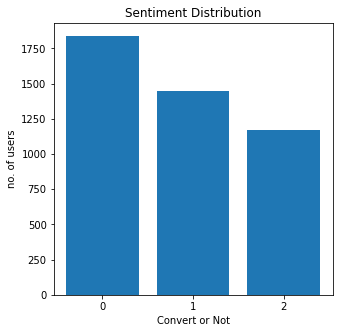

In [48]:
plt.figure(figsize=(5,5))
x=range(3)
plt.bar(x,sentiment_rate['clean_text'])
plt.xticks(sentiment_rate.index)
plt.title('Sentiment Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

#Data is imbalanced

### map text in data to class

In [49]:
topics_map = {'Store': 0, 'Logistics': 1, 'Promotion': 2, 'Company': 3, 'System': 4}
df['Topics'] = df.Topics.map(topics_map)

In [50]:
df['Topics']

0       3
1       3
2       3
3       3
4       3
       ..
4453    4
4454    4
4455    4
4456    4
4457    4
Name: Topics, Length: 4458, dtype: int64

In [51]:
print(df.Topics.value_counts())

0    1571
1    1121
4     626
2     605
3     535
Name: Topics, dtype: int64


## Fixing imbalanced with Undersampling

In [180]:
from sklearn.model_selection import train_test_split

X = X_train_tfidf
y = df['Topics']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [183]:
from imblearn.under_sampling import RandomUnderSampler
sampling_strategy = {0: 427, 1:427, 2:427, 3:427, 4:427}
rus = RandomUnderSampler(sampling_strategy = sampling_strategy).fit(X_train, y_train)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_resampled),pd.DataFrame(data=y_resampled)], axis=1, sort=False)
df_undersampled.columns= ['Topics','clean_text']

In [184]:
from collections import Counter
print('Before Value Counts:\n{}\n'.format(Counter(y_train)))
print('df shape     :{}'.format(df.shape))
print('X_train shape before:{}'.format(X_train.shape))
print('y_train shape before:{}'.format(y_train.shape))
print('X_test shape before :{}'.format(X_test.shape))
print('y_test shape before :{}\n'.format(y_test.shape))
print('X_train shape after :{}'.format(X_resampled.shape))
print('y_train shape after :{}\n'.format(y_resampled.shape))
print('Target Value Counts:\n{}\n'.format(Counter(y_resampled)))

Before Value Counts:
Counter({0: 1260, 1: 890, 4: 502, 2: 487, 3: 427})

df shape     :(4458, 3)
X_train shape before:(3566, 111)
y_train shape before:(3566,)
X_test shape before :(892, 111)
y_test shape before :(892,)

X_train shape after :(2135, 111)
y_train shape after :(2135,)

Target Value Counts:
Counter({0: 427, 1: 427, 2: 427, 3: 427, 4: 427})



## SVM

In [185]:
svm_clf_model = LinearSVC().fit(X_resampled, y_resampled)
y_predict_svm = svm_clf_model.predict(X_test)

In [186]:
print('test')
print(classification_report(y_test,y_predict_svm))
print(confusion_matrix(y_test,y_predict_svm))

test
              precision    recall  f1-score   support

           0       0.79      0.60      0.68       311
           1       0.66      0.62      0.64       231
           2       0.55      0.75      0.64       118
           3       0.76      0.92      0.83       108
           4       0.71      0.85      0.77       124

    accuracy                           0.70       892
   macro avg       0.70      0.75      0.71       892
weighted avg       0.71      0.70      0.70       892

[[187  49  41  10  24]
 [ 35 144  22  17  13]
 [ 13  12  88   3   2]
 [  1   3   2  99   3]
 [  2  10   6   1 105]]


## Cross Validation

In [187]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [188]:
y_train_pred_svm = cross_val_predict(svm_clf_model, X_resampled, y_resampled, cv=5, n_jobs=-1)
#print(y_train_pred_svm)
name = ['Store', 'Logistics', 'Promotion', 'Company', 'System']
print('train')
print(classification_report(y_resampled, y_train_pred_svm,target_names = name ))

train
              precision    recall  f1-score   support

       Store       0.63      0.61      0.62       427
   Logistics       0.67      0.63      0.65       427
   Promotion       0.74      0.70      0.72       427
     Company       0.86      0.90      0.88       427
      System       0.75      0.80      0.78       427

    accuracy                           0.73      2135
   macro avg       0.73      0.73      0.73      2135
weighted avg       0.73      0.73      0.73      2135



## Grid Search

In [206]:
from sklearn.model_selection import GridSearchCV 
from sklearn import svm
# grid_params_svm = {
#     'classifier__C': [0.01,0.5,1,1.5],
#     'classifier__penalty' :['l1', 'l2']
#     }
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
gs_svm = GridSearchCV(svc,parameters,verbose=1,cv=20,n_jobs=-1)
gs_results_svm = gs_svm.fit(X_resampled, y_resampled)
gs_results_svm.best_score_
gs_results_svm.best_estimator_
gs_results_svm.best_params_
best_svm = gs_results_svm.best_estimator_

y_pred_svm = best_svm.predict(X_test)
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

Fitting 20 folds for each of 4 candidates, totalling 80 fits
[[203  54  31   8  15]
 [ 38 155  16  12  10]
 [ 17  15  81   2   3]
 [  2   3   2  96   5]
 [  3   8   5   1 107]]
              precision    recall  f1-score   support

           0       0.77      0.65      0.71       311
           1       0.66      0.67      0.67       231
           2       0.60      0.69      0.64       118
           3       0.81      0.89      0.85       108
           4       0.76      0.86      0.81       124

    accuracy                           0.72       892
   macro avg       0.72      0.75      0.73       892
weighted avg       0.72      0.72      0.72       892



## RandomForest

In [190]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier().fit(X_resampled, y_resampled)
rf_pred = rf_clf.predict(X_test)

In [191]:
print('test')
name = ['Store', 'Logistics', 'Promotion', 'Company', 'System']
print(classification_report(y_test,rf_pred,target_names = name))
print(confusion_matrix(y_test,rf_pred ))

test
              precision    recall  f1-score   support

       Store       0.76      0.63      0.69       311
   Logistics       0.65      0.65      0.65       231
   Promotion       0.55      0.68      0.61       118
     Company       0.83      0.90      0.86       108
      System       0.75      0.85      0.80       124

    accuracy                           0.71       892
   macro avg       0.71      0.74      0.72       892
weighted avg       0.71      0.71      0.70       892

[[196  55  36   7  17]
 [ 38 151  22  10  10]
 [ 17  15  80   2   4]
 [  1   2   4  97   4]
 [  5  10   3   1 105]]


In [192]:
# # Grid Search fine tune model Random forest
# from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV

# rf_params = {"n_estimators":[100,300,500],
#                   "max_depth":[7,10,15],
#                   "max_features": [8,10,15],
#                   "min_samples_split": [4,6,8]}


# rf_grid= RandomizedSearchCV(rf_clf, rf_params, cv = 5, n_iter=10,
#                                  n_jobs = -1, verbose = 2,scoring='f1').fit(X1, y1)

# rf_grid.best_params_

# n_estimators = ,min_samples_split = 8,max_features = 15,max_depth = 15

## Cross Validation

In [193]:
y_train_pred_rf = cross_val_predict(rf_clf, X_resampled, y_resampled, cv=5, n_jobs=-1)
#print(y_train_pred_svm)
name = ['Store', 'Logistics', 'Promotion', 'Company', 'System']
print(classification_report(y_resampled, y_train_pred_rf, target_names = name ))

              precision    recall  f1-score   support

       Store       0.61      0.64      0.62       427
   Logistics       0.63      0.69      0.66       427
   Promotion       0.78      0.67      0.73       427
     Company       0.89      0.90      0.90       427
      System       0.83      0.81      0.82       427

    accuracy                           0.74      2135
   macro avg       0.75      0.74      0.74      2135
weighted avg       0.75      0.74      0.74      2135



## Grid Search

In [210]:
from sklearn.model_selection import GridSearchCV 
from sklearn import svm
# grid_params_svm = {
#     'classifier__C': [0.01,0.5,1,1.5],
#     'classifier__penalty' :['l1', 'l2']
#     }
rf_params = {"n_estimators":[1000],
                   "max_depth":[15],
                   "max_features": [15],
                   "min_samples_split": [4]}

#svc = svm.SVC()
gs_svm = GridSearchCV(rf_clf,rf_params,verbose=1,cv=10,n_jobs=-1)
gs_results_svm = gs_svm.fit(X_resampled, y_resampled)
gs_results_svm.best_score_
gs_results_svm.best_estimator_
gs_results_svm.best_params_
best_svm = gs_results_svm.best_estimator_

y_pred_svm = best_svm.predict(X_test)
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[[212  54  26   8  11]
 [ 45 148  20   9   9]
 [ 17  15  81   2   3]
 [  2   1   4  99   2]
 [  3   7   3   1 110]]
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       311
           1       0.66      0.64      0.65       231
           2       0.60      0.69      0.64       118
           3       0.83      0.92      0.87       108
           4       0.81      0.89      0.85       124

    accuracy                           0.73       892
   macro avg       0.73      0.76      0.75       892
weighted avg       0.73      0.73      0.73       892



## Logistics Regression

In [195]:
from sklearn.linear_model import LogisticRegression
lr_clf_lg = LogisticRegression(random_state=0).fit(X_resampled, y_resampled)
lr_pred_lg = lr_clf_lg.predict(X_test)

In [196]:
print('test')
name = ['Store', 'Logistics', 'Promotion', 'Company', 'System']
print(classification_report(y_test,lr_pred_lg,target_names = name))
print(confusion_matrix(y_test,lr_pred_lg))

test
              precision    recall  f1-score   support

       Store       0.77      0.59      0.67       311
   Logistics       0.66      0.65      0.65       231
   Promotion       0.55      0.72      0.62       118
     Company       0.78      0.91      0.84       108
      System       0.71      0.82      0.76       124

    accuracy                           0.70       892
   macro avg       0.69      0.74      0.71       892
weighted avg       0.71      0.70      0.69       892

[[185  52  41  10  23]
 [ 34 150  21  14  12]
 [ 15  14  85   2   2]
 [  1   2   3  98   4]
 [  5  10   5   2 102]]


## Cross Validation

In [197]:
y_train_pred_lg = cross_val_predict(lr_clf_lg, X_resampled, y_resampled, cv=5, n_jobs=-1)
#print(y_train_pred_svm)
name = ['Store', 'Logistics', 'Promotion', 'Company', 'System']
print(classification_report(y_resampled, y_train_pred_lg, target_names=name ))

              precision    recall  f1-score   support

       Store       0.63      0.62      0.63       427
   Logistics       0.65      0.67      0.66       427
   Promotion       0.75      0.71      0.73       427
     Company       0.87      0.88      0.88       427
      System       0.77      0.80      0.78       427

    accuracy                           0.73      2135
   macro avg       0.73      0.73      0.73      2135
weighted avg       0.73      0.73      0.73      2135



In [198]:
from sklearn.model_selection import GridSearchCV 
# from sklearn import svm
# grid_params_svm = {
#     'classifier__C': [0.01,0.5,1,1.5],
#     'classifier__penalty' :['l1', 'l2']
#     }

penalty = ['l1', 'l2']
C = np.logspace(-4,4,20)
hyperparameters = dict(penalty=penalty, C=C)

#svc = svm.SVC()
gs_lr = GridSearchCV(lr_clf_lg,hyperparameters,verbose=1,cv=5,n_jobs=-1)
gs_results_lr = gs_lr.fit(X_resampled, y_resampled)
gs_results_lr.best_score_
gs_results_lr.best_estimator_
gs_results_lr.best_params_
best_lr = gs_results_lr.best_estimator_

y_pred_lr = best_lr.predict(X_test)
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[[191  50  37  10  23]
 [ 35 151  20  14  11]
 [ 15  14  84   3   2]
 [  1   2   3  98   4]
 [  5  10   4   3 102]]
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       311
           1       0.67      0.65      0.66       231
           2       0.57      0.71      0.63       118
           3       0.77      0.91      0.83       108
           4       0.72      0.82      0.77       124

    accuracy                           0.70       892
   macro avg       0.70      0.74      0.71       892
weighted avg       0.71      0.70      0.70       892



/Users/abcd/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.53208431        nan 0.63559719        nan 0.67447307
        nan 0.68665105        nan 0.69133489        nan 0.69929742
        nan 0.70913349        nan 0.72177986        nan 0.72318501
        nan 0.73302108        nan 0.73255269        nan 0.72786885
        nan 0.72224824        nan 0.7175644         nan 0.71522248
        nan 0.71662763        nan 0.71428571        nan 0.71522248
        nan 0.71615925        nan 0.71428571]
  category=UserWarning


## Naive Bayes

In [199]:
from sklearn.naive_bayes import MultinomialNB
lr_clf_NB = MultinomialNB().fit(X_resampled, y_resampled)
lr_pred_NB = lr_clf_NB.predict(X_test)

In [200]:
print('test')
name = ['Store', 'Logistics', 'Promotion', 'Company', 'System']
print(classification_report(y_test,lr_pred_NB,target_names = name))
print(confusion_matrix(y_test,lr_pred_NB))

test
              precision    recall  f1-score   support

       Store       0.69      0.64      0.67       311
   Logistics       0.68      0.56      0.61       231
   Promotion       0.56      0.70      0.62       118
     Company       0.78      0.91      0.84       108
      System       0.68      0.76      0.71       124

    accuracy                           0.68       892
   macro avg       0.68      0.71      0.69       892
weighted avg       0.68      0.68      0.67       892

[[200  38  35  13  25]
 [ 56 129  23   9  14]
 [ 17  12  83   2   4]
 [  2   3   3  98   2]
 [ 13   9   5   3  94]]


## Cross Validation

In [111]:
y_train_pred_NB = cross_val_predict(lr_clf_NB, X_resampled, y_resampled, cv=5, n_jobs=-1)
#print(y_train_pred_svm)
name = ['Store', 'Logistics', 'Promotion', 'Company', 'System']
print(classification_report(y_resampled, y_train_pred_NB,target_names = name ))

              precision    recall  f1-score   support

       Store       0.56      0.66      0.60       427
   Logistics       0.61      0.58      0.59       427
   Promotion       0.71      0.66      0.69       427
     Company       0.87      0.87      0.87       427
      System       0.78      0.73      0.76       427

    accuracy                           0.70      2135
   macro avg       0.70      0.70      0.70      2135
weighted avg       0.70      0.70      0.70      2135

